In [1]:
import networkx as nx
import nx_parallel as nxp
import osmnx as ox 
import geopandas as gpd 

In [2]:
nx.config.backends.parallel.active = True
nx.config.backends.parallel.n_jobs = 4

In [3]:
abq = gpd.read_file("../../data/local/abq_shp.gpkg")
abq

,geometry
0,"POLYGON ((-106.7514 35.02437, -106.7514 35.227..."


In [4]:
from shapely.geometry import Polygon
abq_poly = abq.loc[0,"geometry"]
type(abq_poly)

shapely.geometry.polygon.Polygon

In [5]:
G = ox.graph.graph_from_polygon(abq_poly, network_type="drive")

In [6]:
M = ox.convert.to_undirected(G)
D = ox.convert.to_digraph(G)

In [7]:
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
print(gdf_nodes.head())
print(gdf_edges.head())

                   y           x  street_count          highway  ref junction  \
osmid                                                                           
140740032  35.191400 -106.662981             3              NaN  NaN      NaN   
140740051  35.188395 -106.665043             4  traffic_signals  NaN      NaN   
140740067  35.186321 -106.668390             4              NaN  NaN      NaN   
140740077  35.184815 -106.670264             4              NaN  NaN      NaN   
140740087  35.184565 -106.672950             5              NaN  NaN      NaN   

                              geometry  
osmid                                   
140740032   POINT (-106.66298 35.1914)  
140740051  POINT (-106.66504 35.18839)  
140740067  POINT (-106.66839 35.18632)  
140740077  POINT (-106.67026 35.18481)  
140740087  POINT (-106.67295 35.18456)  
                              osmid      highway                        name  \
u         v          key                                         

In [8]:
G2 = ox.convert.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# Basic street network stats

>Coverage area

In [9]:
G_proj = ox.projection.project_graph(G)
nodes_proj = ox.convert.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.union_all().convex_hull.area
print(graph_area_m)

561494459.9039172


In [10]:
ox.stats.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 26787,
 'm': 66854,
 'k_avg': 4.991525740097809,
 'edge_length_total': 8819397.911364075,
 'edge_length_avg': 131.92027270416241,
 'streets_per_node_avg': 2.861873296748423,
 'streets_per_node_counts': {0: 0,
  1: 5060,
  2: 192,
  3: 15125,
  4: 6220,
  5: 178,
  6: 12},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.18889759958188673,
  2: 0.0071676559525142795,
  3: 0.5646395639675962,
  4: 0.23220218762832717,
  5: 0.006645014372643447,
  6: 0.00044797849703214247},
 'intersection_count': 21727,
 'street_length_total': 5066464.423931445,
 'street_segment_count': 38356,
 'street_length_avg': 132.09053144049028,
 'circuity_avg': 1.0566290393465019,
 'self_loop_proportion': 0.002789654812806341,
 'clean_intersection_count': 17243,
 'node_density_km': 47.7066149585586,
 'intersection_density_km': 38.69494990870955,
 'edge_density_km': 15707.007889041768,
 'street_density_km': 9023.177939811583,
 'clean_intersection_density_km': 30.70911866690656}

In [11]:
ox.io.save_graph_geopackage(G, filepath="../../data/local/abq_network.gpkg")
ox.io.save_graphml(G, filepath="../../data/abq_network.graphml")

# Visualize street centrality

In [13]:
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

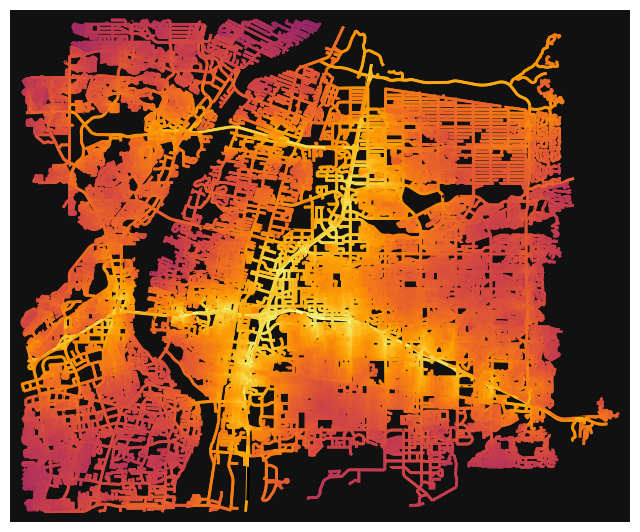

In [31]:
ec = ox.plot.get_edge_colors_by_attr(
    G, "edge_centrality", cmap='inferno'
)
fig, ax = ox.plot.plot_graph(G, 
                             edge_color=ec, 
                             edge_linewidth=2, 
                             node_size=0);

In [14]:
ox.io.save_graph_geopackage(G, filepath="../../data/local/abq_network.gpkg")
ox.io.save_graphml(G, filepath="../../data/abq_network.graphml")

# Routing
impute missing edge speeds and calculate edge travel times

In [15]:
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

In [16]:
pois = gpd.read_file("../../data/local/poi.gpkg")
pois.columns

Index(['address', 'id', 'name', 'addr', 'geometry'], dtype='object')

In [17]:
pois

,address,id,name,addr,geometry
0,"6119, Mustang Lane Northwest, Albuquerque, Ber...",1,Home,"6119 Mustang Ln NW, Albuquerque, NM 87120",POINT (-106.70813 35.14749)
1,"Sprouts Farmers Market, 5600, Coors Boulevard ...",2,Sprouts,"5600 Coors Blvd NW, Albuquerque, NM 78120",POINT (-106.68659 35.14657)
2,"Don Newton Taylor Ranch Community Center, 4900...",3,Community Center,"4900 Kachina NW, Albuquerque, NM 87120",POINT (-106.6947 35.15459)
3,"ABQ BioPark: Zoo, Aquarium, Botanic Garden, 26...",4,Botanical Gardens,"2601 Central Ave NW, Albuquerque, NM 87104",POINT (-106.68555 35.09676)
4,"University of New Mexico, Princeton Drive Nort...",5,UNM,"University of New Mexico, Albuquerque, NM 87131",POINT (-106.62021 35.08663)


In [38]:
ogeo = pois.iloc[0]["geometry"]
dgeo = pois.iloc[4]["geometry"]

In [39]:
ogeo.x, ogeo.y

(-106.70813463265306, 35.14749489795918)

In [40]:
dgeo.x, dgeo.y

(-106.62020940505188, 35.08663275)

In [41]:
orig = ox.distance.nearest_nodes(G, X=ogeo.x, Y=ogeo.y)
dest = ox.distance.nearest_nodes(G, X=dgeo.x, Y=dgeo.y)

In [42]:
route = ox.routing.shortest_path(G, orig, dest, weight="travel_time")

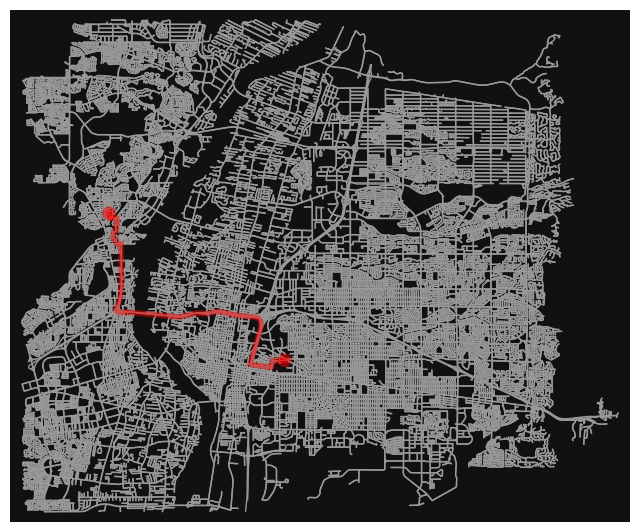

In [43]:
fig, ax = ox.plot.plot_graph_route(G, route, node_size=0)

In [48]:
idx = pois.loc[pois["name"] == 'UNM'].index

In [65]:
dw = pois.iloc[idx[0]]["geometry"].x
dw

-106.62020940505188

In [57]:
w = pois.iloc[4]["geometry"].x
w

-106.62020940505188

>Length of route

In [66]:
edge_lengths = ox.routing.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

15979

>direct path between the points

In [67]:
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))

10473

# Features

In [68]:
tags = {"building": True}
gdf = ox.features.features_from_polygon(abq_poly, tags)
gdf.shape

(209886, 373)

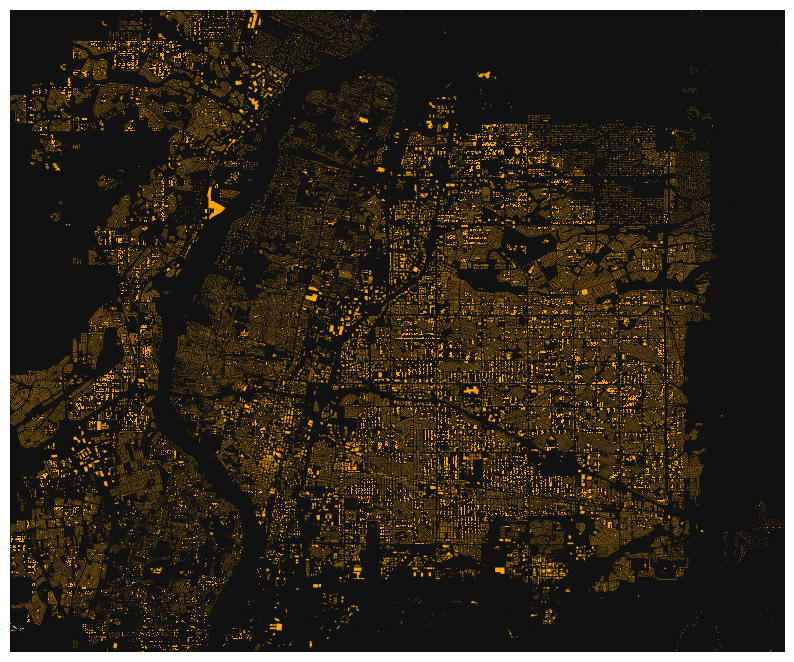

In [69]:
fig, ax = ox.plot.plot_footprints(gdf, figsize=(10,10))

In [71]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features.features_from_polygon(abq_poly, tags)
gdf.shape

(757, 69)

In [83]:
import contextily as ctx
gdf.park

element  id        
node     357572294     NaN
         357579064     NaN
         357592018     NaN
         357592145     NaN
         357594782     NaN
                      ... 
way      1266445166    NaN
         1304338967    NaN
         1304965422    NaN
         1327542323    NaN
         1339160555    NaN
Name: park, Length: 757, dtype: object

KeyError: 'geometry'

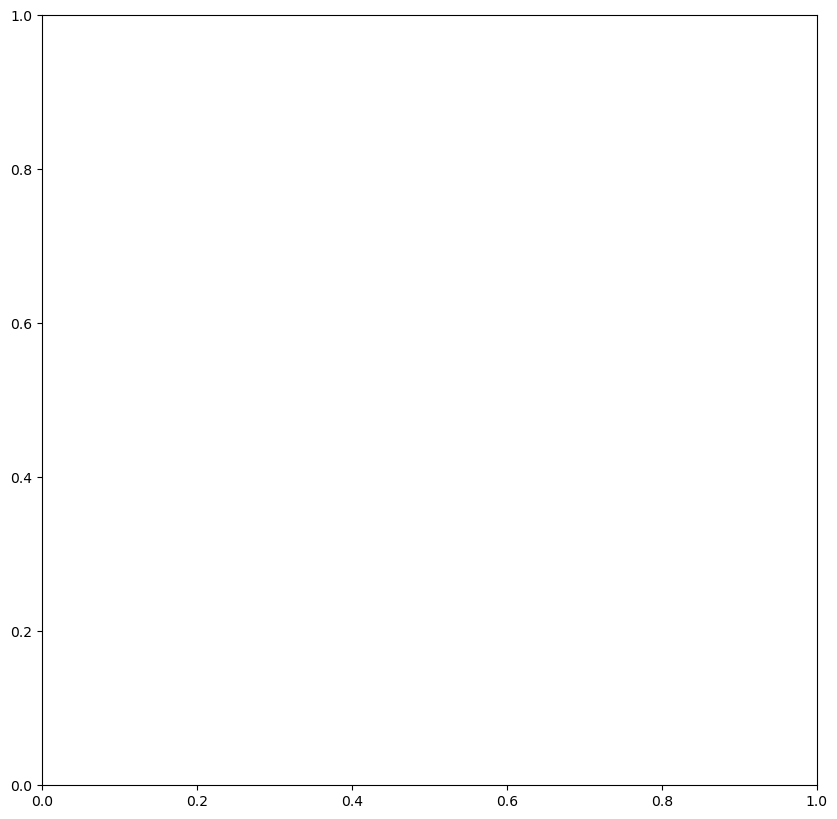

In [82]:
ax = ox.plot.plot_footprints(gdf['park'], 
                                  figsize=(10,10),
                                  color='black', 
                                  bgcolor='white')

In [78]:
gdf['park']

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich